In [1]:
import tensorflow as tf

# Load cifar dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

2024-06-14 12:26:40.060062: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 12:26:40.642150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices('GPU')

2024-06-14 12:26:42.145625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 12:26:42.169553: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 12:26:42.169632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
import cv2

# Get Input image for VGG16
x_train_vgg = np.array([cv2.resize(img, (80, 80)) for img in x_train])
x_test_vgg = np.array([cv2.resize(img, (80, 80)) for img in x_test])

In [4]:
x_train_vgg.shape

(50000, 80, 80, 3)

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
# Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train_vgg, x_test_vgg = x_train_vgg / 255.0, x_test_vgg / 255.0

y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [7]:
num_classes = 10
input_shape = (32, 32, 3)

# Define Hyperparameter
# ViT Base
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 15  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 12
final_dropout_layer = 0.5
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12
mlp_head_units = [
    3072,
]

config_json = {   
    "learning_rate" : learning_rate,
    "batch_size" : batch_size,
    "num_epochs" : num_epochs,
    "image_size" : image_size,
    "patch_size" : patch_size,
    "num_patches" : num_patches,
    "projection_dim" : projection_dim,
    "num_heads" : num_heads,
    "final_dropout_layer" : final_dropout_layer,
    "transformer_units" : transformer_units,
    "transformer_layers" : transformer_layers,
    "mlp_head_units" : mlp_head_units
}

In [8]:
from modules.vision_transformers.patches import Patches
from modules.vision_transformers.patch_encoder import PatchEncoder, mlp

# Data Augmentation for resize
data_augmentation = tf.keras.Sequential([
    #tf.keras.layers.Normalization(),
    tf.keras.layers.Resizing(image_size, image_size),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.02),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    #tf.keras.layers.RandomContrast(factor=0.1)
])

# Compute the average and variance of the training data for normalization purpose
#data_augmentation.layers[0].adapt(x_train)

2024-06-14 12:26:45.178868: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 12:26:45.179013: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 12:26:45.179045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 12:26:45.961736: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 12:26:45.961825: I external/local_xla/xla/stream_executor

In [9]:
vgg_conv = tf.keras.applications.VGG16(
        include_top=False,
        #input_shape=(64, 64, 3),
        weights='imagenet',
        classifier_activation=None
    )

# Define the model
def create_classifier():
    # Inputs for CNN
    inputs_cnn = tf.keras.layers.Input(shape=(80, 80, 3))

    output_vgg16 = vgg_conv(inputs_cnn)
    outputs_cnn = tf.keras.layers.Flatten()(output_vgg16)
    outputs_cnn = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs_cnn)
    
    # Input for Transformer
    inputs_transformers = tf.keras.Input(shape=input_shape)
    
    # Apply augment resize
    augmented = data_augmentation(inputs_transformers)
    
    # Create Patches
    patches = Patches(patch_size)(augmented)

    # Encode every patches position
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        # Create multilayers about how many transformers layer needed
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
        # Create a multi-head attention layer
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

        # layer normalization 2
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)

        # NLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip Connection
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dense(outputs_cnn.shape[1], activation='relu')(representation)
    representation_transformers = tf.keras.layers.Dropout(final_dropout_layer)(representation)

    # Concat
    #concatenated = tf.keras.layers.Concatenate()([outputs_cnn, representation_transformers])
    # Concat
    concatenated = tf.keras.layers.Add()([outputs_cnn, representation_transformers])
    concatenated = tf.keras.layers.LayerNormalization(epsilon=1e-6)(concatenated)
    
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=final_dropout_layer)
    
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(concatenated)
    # Create the Keras model.
    model = tf.keras.Model(inputs=[inputs_cnn, inputs_transformers], outputs=logits)
    
    return model

model = create_classifier()

In [10]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 72, 72, 3) │          0 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Patches)   │ (None, 144, 108)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 144, 64)   │     16,192 │ patches[0][0]     │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │    198,976 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 144, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 144, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 144, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 144, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │    198,976 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 144, 128)  │          0 │ dense_3[0][0]   

 Total params: 36,225,802 (138.19 MB)

 Trainable params: 36,225,802 (138.19 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
total_steps = len(x_train) * num_epochs
decay_steps = total_steps * 0.4
# Cosine Learning Rate Decay
cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    alpha=0.1,
    warmup_steps=15000
)

In [12]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=cosine_decay_scheduler),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(3, name='top-5-accuracy')
    ]
)

In [13]:
history = model.fit(
    x=[x_train_vgg, x_train],
    y=y_train_categorical,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=([x_test_vgg, x_test], y_test_categorical)
)

2024-06-14 12:26:49.616849: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3840000000 exceeds 10% of free system memory.
2024-06-14 12:26:51.798273: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3840000000 exceeds 10% of free system memory.


Epoch 1/15


2024-06-14 12:27:21.949072: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 982s 304ms/step - accuracy: 0.1776 - loss: 2.4017 - top-5-accuracy: 0.4423 - val_accuracy: 0.3696 - val_loss: 1.6713 - val_top-5-accuracy: 0.7282
Epoch 2/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 922s 295ms/step - accuracy: 0.4102 - loss: 1.5889 - top-5-accuracy: 0.7637 - val_accuracy: 0.4845 - val_loss: 1.4349 - val_top-5-accuracy: 0.8146
Epoch 3/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 926s 296ms/step - accuracy: 0.4973 - loss: 1.3841 - top-5-accuracy: 0.8268 - val_accuracy: 0.5704 - val_loss: 1.2192 - val_top-5-accuracy: 0.8674
Epoch 4/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 930s 298ms/step - accuracy: 0.5682 - loss: 1.2062 - top-5-accuracy: 0.8647 - val_accuracy: 0.6185 - val_loss: 1.1087 - val_top-5-accuracy: 0.8858
Epoch 5/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 928s 297ms/step - accuracy: 0.6232 - loss: 1.0646 - top-5-accuracy: 0.8906 - val_accuracy: 0.6552 - val_loss: 1.0094 - val_top-5-accuracy: 0.9038
Epoch 6/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 924s 296ms/step - accuracy: 0

In [14]:
x_test_vgg.shape

(10000, 80, 80, 3)

In [15]:
evaluated = model.evaluate([x_test_vgg, x_test], y_test_categorical)
final_acc, final_loss, final_top_3_acc = evaluated[0], evaluated[1], evaluated[2]

313/313 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.7828 - loss: 1.0252 - top-5-accuracy: 0.9507


In [16]:
save_name = 'model/model_cifar10_vgg_add_val'

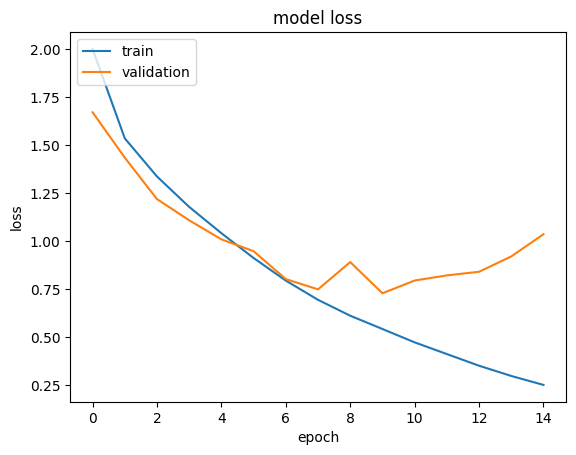

In [17]:
import matplotlib.pyplot as plt

# Save Train result
fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
fig.savefig(save_name + "_loss.jpg")

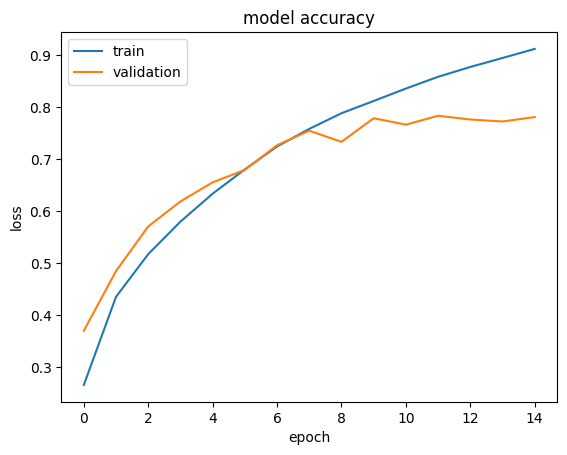

In [19]:
# Save Train result
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
fig.savefig(save_name + "_accuracy.jpg")

In [21]:
model.save('{}.keras'.format(save_name))

In [22]:
import json

config_json['final_accuracy'] = final_acc,
config_json['final_loss'] = final_loss
config_json['final_top_3_acc'] = final_top_3_acc
with open('{}_config.json'.format(save_name), 'w') as f:
    json.dump(config_json, f, indent=4)